# **Загрузка библиотек**

In [196]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import nbformat
import plotly.graph_objects as go
import cmath 

from scipy.stats import normaltest, levene, norm
from scipy.optimize import curve_fit
from scipy.stats import f_oneway
from scipy.fft import fft, fftfreq, rfft, rfftfreq, irfft, ifft

sns.set_theme()
sns.set_palette("deep")

# **Acceleration in Booster measured with FCT**

## Booster parameters

In [313]:
m_p = 938.256 * 10**6 # масса покоя протона 
M_p = 1.67252 * 10**(-24) # тоже самое только в кг (но нужно проверить)
m_pn = 938.2 * 10**6 # масса покоя нейрона 
m_e = 0.5111006 * 10**6 # масса покоя элктрона 

Z = 28 # зарядовое число 
A = 124 # массовое число
C = 21096 # периметр бустера в мм
e_SI = 1.6021 * 10**(-19) # заряд электрона в Кл 
e_conv = 299.7925 # ПОСМОТРЕТЬ (коэф перевода )
M_e = 9.109383 * 10**(-28) # масса электрона кг
e_SGS = 4.80298 * 10*(-10) # заряд электрона СГС 

r_p = (e_conv * e_SGS) / m_p # радиус протона 
r_e = (e_SGS * e_conv) / m_e # радиус электрона

k_b = 1.38054 * 10**(-16) # ----
Z_n = 377 # --- 

## Data reading

In [198]:
skip = 2 * 3.4 * 10e6
delta_T = 2 * 10**(-8)
N_avr = 20

zeros_padding = np.zeros((2,3))

In [199]:
file1_1 = r'BoosterAcceleration1_1half.dat'
file1_2 = r'BoosterAcceleration1_2half.dat'
file2_1 = r'BoosterAcceleration2_1half.dat'
file2_2 = r'BoosterAcceleration2_2half.dat'

In [200]:
with open(file1_1, "rb") as file:
    M1_1 = np.load(file).reshape(-1,3)

with open(file1_2, "rb") as file:
    M1_2 = np.load(file).reshape(-1,3)

with open(file2_1, "rb") as file:
    M2_1 = np.load(file).reshape(-1,3)

with open(file2_2, "rb") as file:
    M2_2 = np.load(file).reshape(-1,3)

In [201]:
i_11 = np.arange(M1_1.shape[0] / N_avr).astype(int)
i_12 = np.arange(M1_2.shape[0] / N_avr - 1).astype(int)
i_21 = np.arange(M2_1.shape[0] / N_avr - 1).astype(int)
i_22 = np.arange(M2_2.shape[0] / N_avr - 1).astype(int)

In [202]:
M1_1 = np.vstack((zeros_padding, M1_1))
M1_2 = np.vstack((zeros_padding, M1_2))
M2_1 = np.vstack((zeros_padding, M2_1))
M2_2 = np.vstack((zeros_padding, M2_2))

In [203]:
t_11 = delta_T * M1_1[N_avr * i_11, 0] # реальное время 
t_21 = delta_T * M2_1[N_avr * i_21, 0]
t_12 = delta_T * (M1_2[N_avr * i_12, 0] + skip / 2)
t_22 = delta_T * (M2_2[N_avr * i_22, 0] + skip / 2)

In [204]:
N_11 = 1 / N_avr * np.array([np.sum(M1_1[N_avr*i:N_avr*i + N_avr, 1]) for i in i_11]) # усреднение амплитуд 
N_21 = 1 / N_avr * np.array([np.sum(M2_1[N_avr*i:N_avr*i + N_avr, 1]) for i in i_21])
N_12 = 1 / N_avr * np.array([np.sum(M1_2[N_avr*i:N_avr*i + N_avr, 1]) for i in i_12])
N_22 = 1 / N_avr * np.array([np.sum(M2_2[N_avr*i:N_avr*i + N_avr, 1]) for i in i_22])

In [205]:
fi_11 = 1 / N_avr * np.array([np.sum(M1_1[N_avr*i:N_avr*i + N_avr, 2]) for i in i_11]) # усреднение фаз 
fi_21 = 1 / N_avr * np.array([np.sum(M2_1[N_avr*i:N_avr*i + N_avr, 2]) for i in i_21])
fi_12 = 1 / N_avr * np.array([np.sum(M1_2[N_avr*i:N_avr*i + N_avr, 2]) for i in i_12])
fi_22 = 1 / N_avr * np.array([np.sum(M2_2[N_avr*i:N_avr*i + N_avr, 2]) for i in i_22])

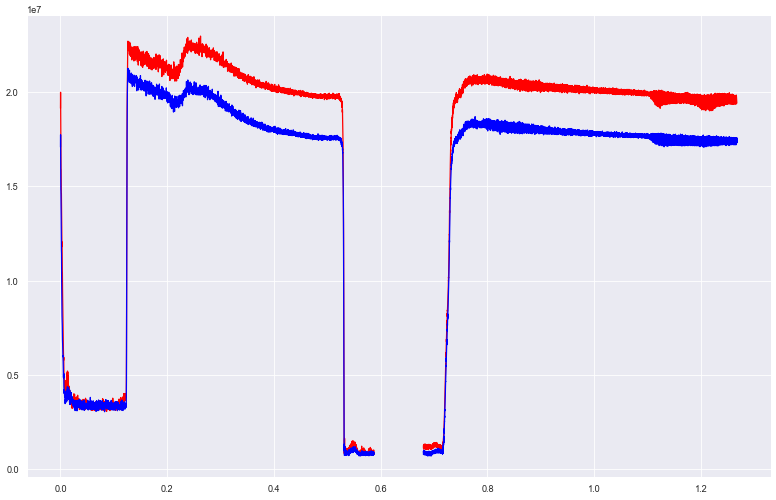

In [206]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(t_11, N_11, color='red')
plt.plot(t_12, N_12, color='red')
plt.plot(t_21, N_21, color='blue')
plt.plot(t_22, N_22, color='blue')

None

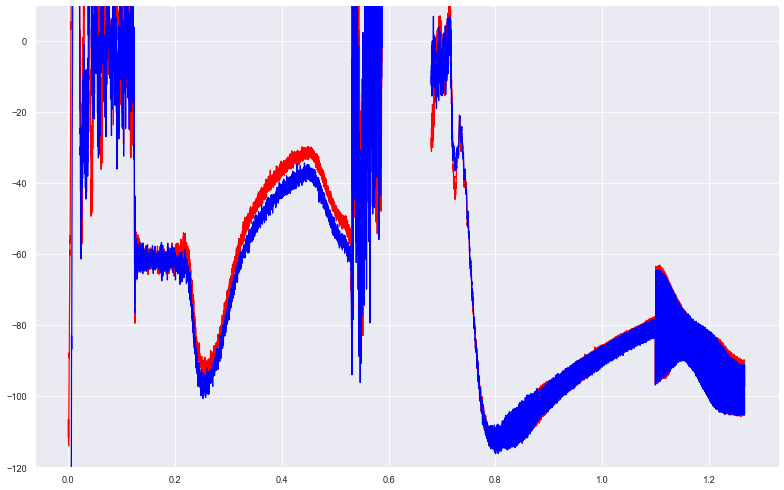

In [207]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(t_11, fi_11, color='red')
plt.plot(t_12, fi_12, color='red')
plt.plot(t_21, fi_21, color='blue')
plt.plot(t_22, fi_22, color='blue')

plt.ylim([-120, 10])

None

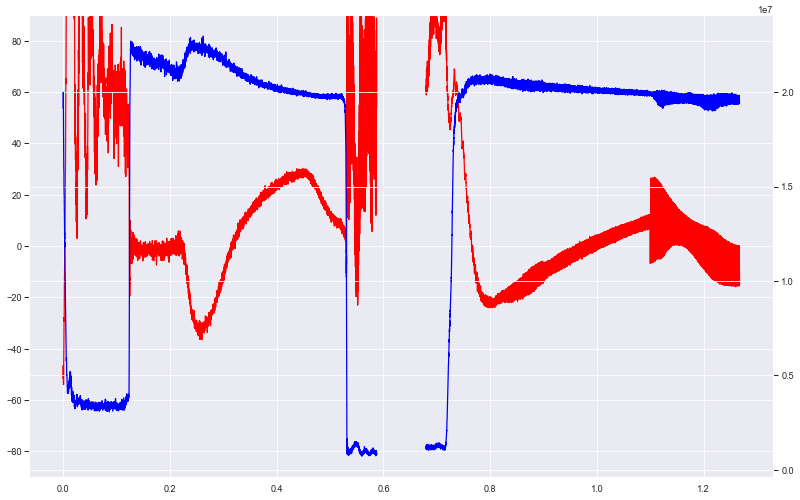

In [208]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(t_11, fi_11 + 60, color='red')
plt.plot(t_12, fi_12 + 90, color='red')

plt.ylim([-90, 90])

plt.twinx()
plt.plot(t_11, N_11, color='blue')
plt.plot(t_22, N_12, color='blue')


None

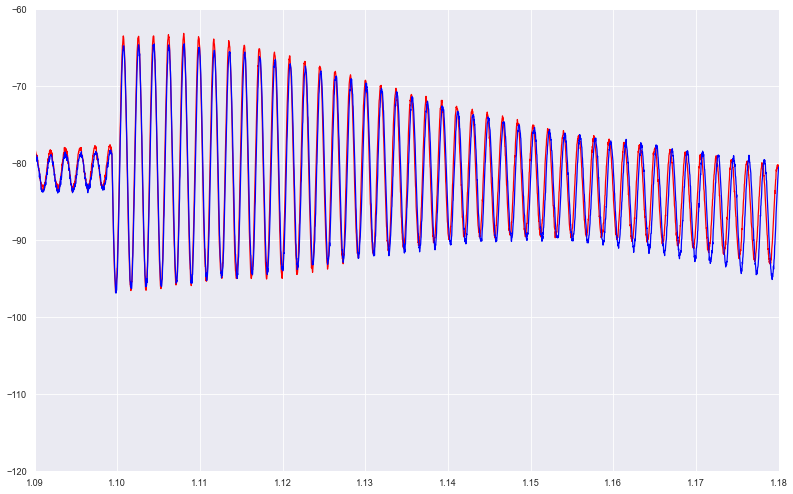

In [209]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(t_11, fi_11, color='red')
plt.plot(t_12, fi_12, color='red')
plt.plot(t_21, fi_21, color='blue')
plt.plot(t_22, fi_22, color='blue')

plt.ylim([-120, -60])
plt.xlim([1.09, 1.18])

None

# лучше сделать два отдельных графика: 1-й участок ускорения 2-второй участок ускорения 

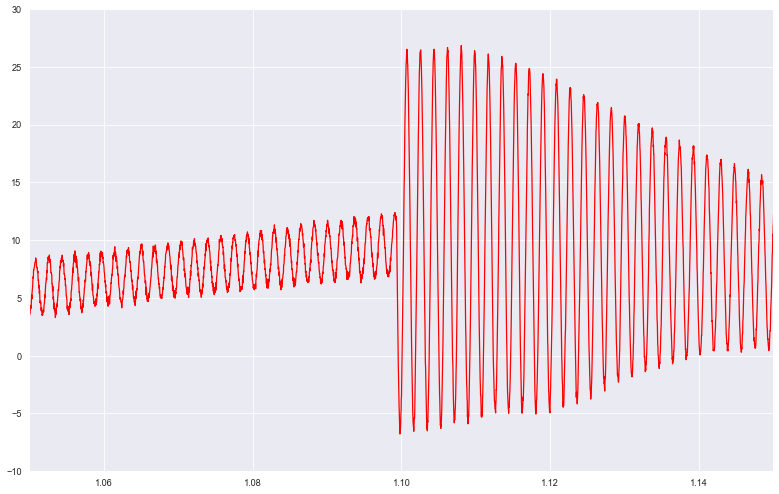

In [210]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(t_11, fi_11 + 90, color='red')
plt.plot(t_12, fi_12 + 90, color='red')

plt.ylim([-10, 30])
plt.xlim([1.05, 1.15])

None

# Booster parameters

In [212]:
ii_11 = np.arange(1, M1_1.shape[0] / N_avr - 2).astype(int)
ii_12 = np.arange(1, M1_2.shape[0] / N_avr - 2).astype(int)
ii_21 = np.arange(1, M2_1.shape[0] / N_avr - 2).astype(int)
ii_22 = np.arange(1, M2_2.shape[0] / N_avr - 2).astype(int)

In [214]:
beta_11 = N_avr * C / (c * (t_11[ii_11+1] - t_11[ii_11])) # Лоренс фактор 
beta_12 = N_avr * C / (c * (t_12[ii_12+1] - t_12[ii_12]))
beta_21 = N_avr * C / (c * (t_21[ii_21+1] - t_21[ii_21]))
beta_22 = N_avr * C / (c * (t_22[ii_22+1] - t_22[ii_22]))

In [215]:
gamma_11 = 1 / np.sqrt(1 - beta_11**2) # Лоренс фактор 
gamma_12 = 1 / np.sqrt(1 - beta_12**2)
gamma_21 = 1 / np.sqrt(1 - beta_21**2)
gamma_22 = 1 / np.sqrt(1 - beta_22**2)

In [216]:
E_11 = (gamma_11 - 1) * m_pn # Полная энергия 
E_12 = (gamma_12 - 1) * m_pn
E_21 = (gamma_21 - 1) * m_pn
E_22 = (gamma_22 - 1) * m_pn

In [217]:
P_11 = beta_11 * gamma_11 * m_pn # Импульс
P_12 = beta_12 * gamma_12 * m_pn
P_21 = beta_21 * gamma_21 * m_pn
P_22 = beta_22 * gamma_22 * m_pn

In [219]:
tt_11 = delta_T * M1_1[N_avr * ii_11, 0]
tt_21 = delta_T * M2_1[N_avr * ii_21, 0]
tt_12 = delta_T * (M1_2[N_avr * ii_12, 0] + skip / 2)
tt_22 = delta_T * (M2_2[N_avr * ii_22, 0] + skip / 2)

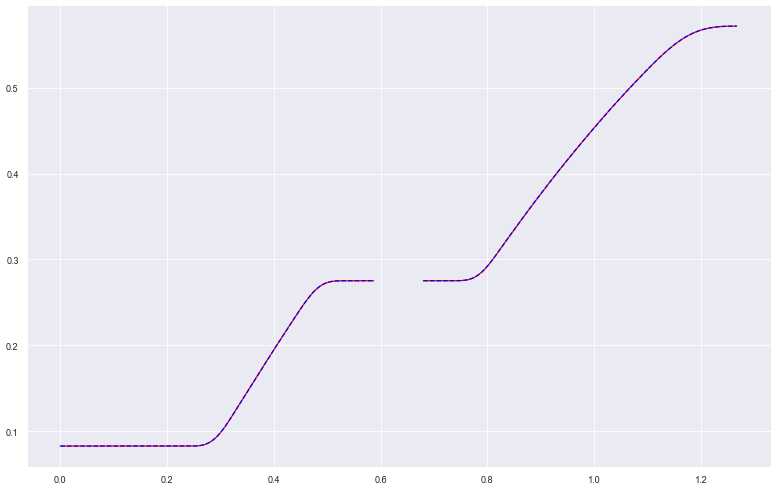

In [220]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(tt_11, beta_11, color='red')
plt.plot(tt_12, beta_12, color='red')
plt.plot(tt_21, beta_21, color='blue', ls='--')
plt.plot(tt_22, beta_22, color='blue', ls='--')

None

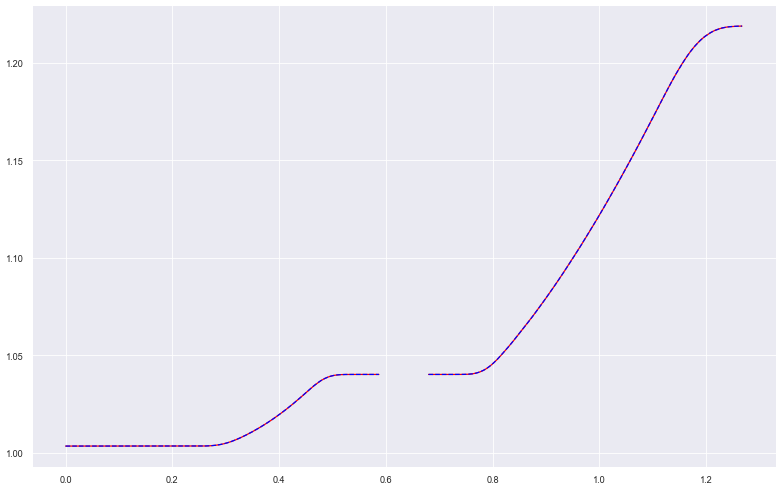

In [221]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(tt_11, gamma_11, color='red')
plt.plot(tt_12, gamma_12, color='red')
plt.plot(tt_21, gamma_21, color='blue', ls='--')
plt.plot(tt_22, gamma_22, color='blue', ls='--')

None

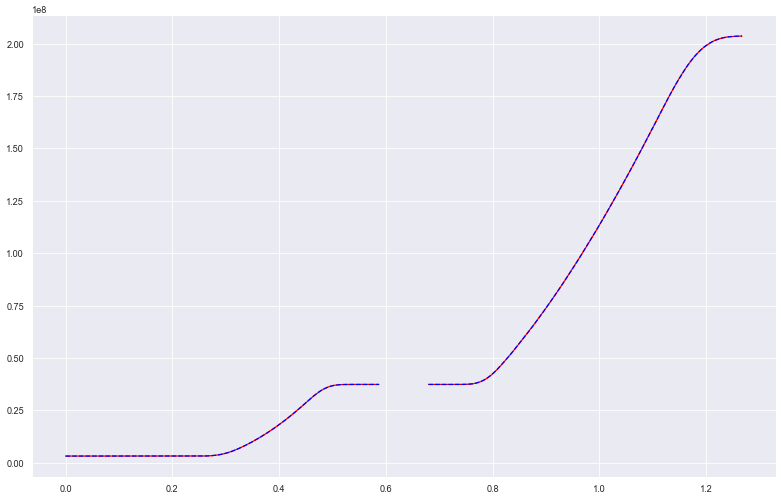

In [222]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(tt_11, E_11, color='red')
plt.plot(tt_12, E_12, color='red')
plt.plot(tt_21, E_21, color='blue', ls='--')
plt.plot(tt_22, E_22, color='blue', ls='--')

None

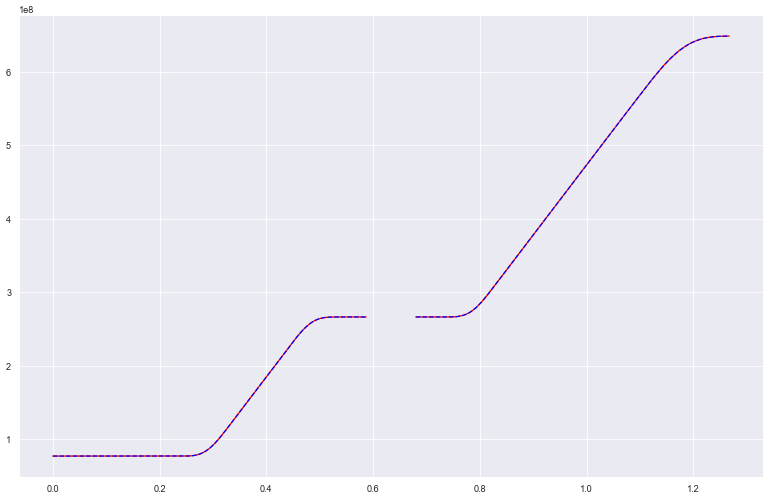

In [223]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(tt_11, P_11, color='red')
plt.plot(tt_12, P_12, color='red')
plt.plot(tt_21, P_21, color='blue', ls='--')
plt.plot(tt_22, P_22, color='blue', ls='--')

None

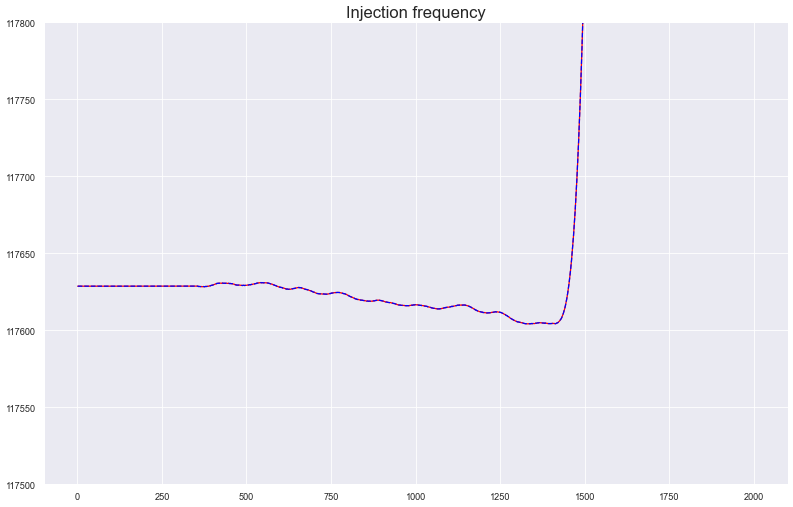

In [253]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(ii_11[:2001], N_avr * (t_11[ii_11+1] - t_11[ii_11])[:2001]**(-1), color='red')
plt.plot(ii_12[:2001], N_avr * (t_11[(ii_12+1)[:2001]] - t_11[ii_12[:2001]])**(-1), color='blue', ls='--')

plt.ylim([1.175 * 10**5, 1.178 * 10**5]) # лучше задать как константы 

plt.title('Injection frequency', fontsize=20)

None

построить график файла B в секундах 

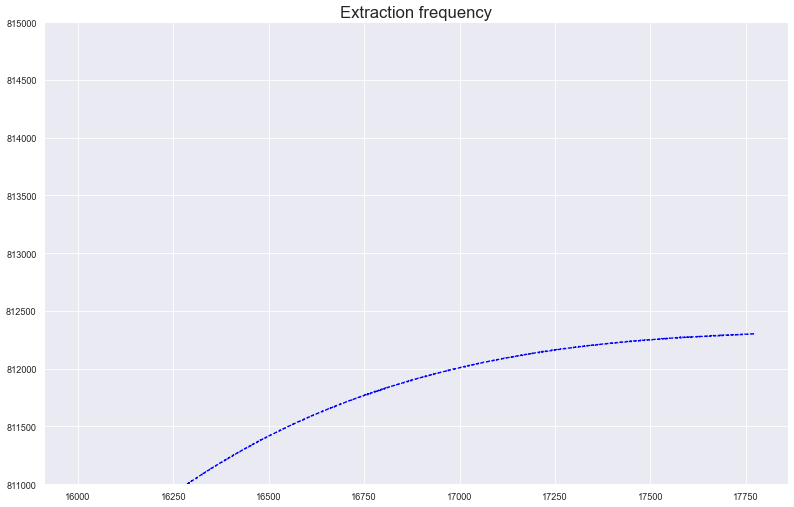

In [258]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(ii_21[16000:], N_avr * (t_21[ii_21+1] - t_11[21_11])[16000:]**(-1), color='red')
plt.plot(ii_22[16000:], N_avr * (t_22[(ii_22+1)[16000:]] - t_22[ii_22[16000:]])**(-1), color='blue', ls='--')

plt.ylim([8.11 * 10**5, 8.15 * 10**5])

plt.title('Extraction frequency', fontsize=20)


None

# аналогично сделать для энергии вывода 

## Reading DCCT and comparing it to FCT 

In [259]:
file_dc = r'booster_data\27_01_23_booster_NPCT_2.bin'

In [260]:
DC = np.fromfile(file_dc, dtype='double')

In [296]:
N_a = 5
delta_t = 1e-3
t_ofs = 0.31

id = np.arange(N_a, len(DC) - N_a)

In [300]:
DC_a = 1 / (500 * (2 * N_a + 1)) * np.array([np.sum(DC[i-N_a:i+N_a+1]) for i in id]) # сглаживание усреднением 

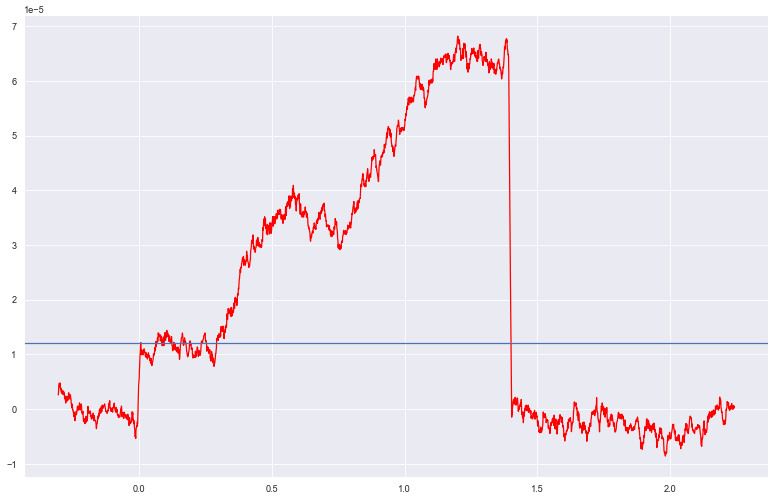

In [302]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(delta_t*id-t_ofs, DC_a, color='red')

plt.axhline(y=12*10**(-6)) # выбирается на глаз, какая интенсивность инжекции 


None

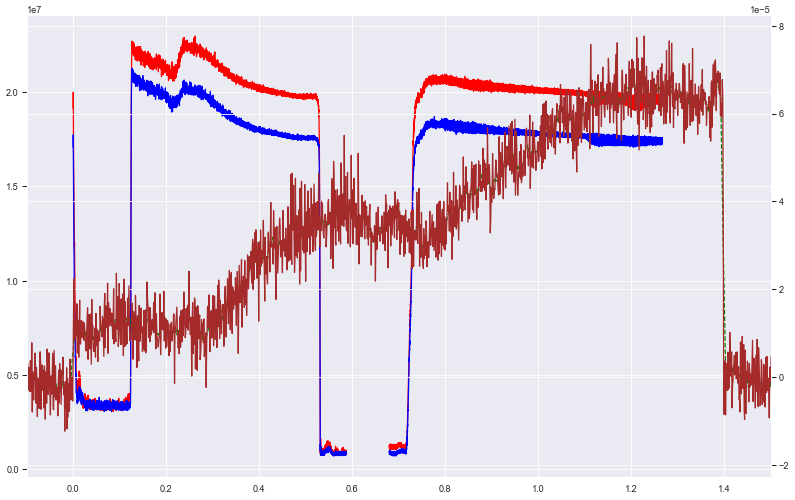

In [308]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(t_11, N_11, color='red')
plt.plot(t_12, N_12, color='red')
plt.plot(t_21, N_21, color='blue')
plt.plot(t_22, N_22, color='blue')

plt.twinx()
plt.plot(delta_t*id-t_ofs, DC_a, color='green', ls='--')
plt.plot(delta_t*id-t_ofs, DC[id] / 500, color='brown')

plt.xlim([-.1, 1.5])

None

In [309]:
file_field = r'booster_data\27_01_23_booster_field_2.bin'

In [311]:
B = np.fromfile(file_field, dtype='double') # данные магнитного поля 

In [312]:
R_B = 1.006 * 221.03 / (2 * np.pi) * (360 / 9)
# (221.03 - поле инжекции в гауссах)

## средний радиус кривизны орбиты 

In [314]:
P_id = Z / A * 10e3 * e_conv * B[id] * R_B # импульс, вычесленный из магнитной жескости пучка на каждом отсчете 

In [316]:
beta_id = P_id / (np.sqrt(P_id**2 + m_pn**2)) # Лоренс фактор 

In [317]:
T_id = C / (beta_id * c) # период обращения 

In [318]:
N_ion = DC_a / (e_SI * Z) * (C / (beta_id * c)) # интенсивность пучка в частицах 

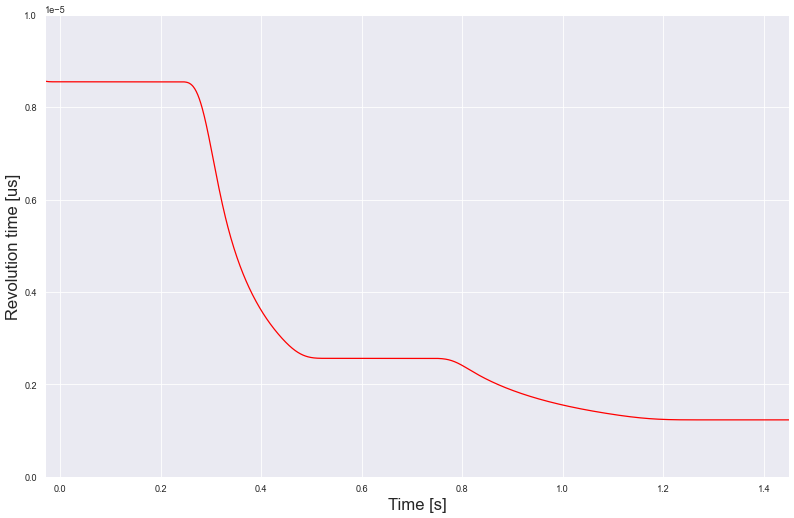

In [331]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(delta_t*id-t_ofs, T_id, color='red')

plt.xlim([-.03, 1.45])
plt.ylim([0, 1*10**(-5)])

plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Revolution time [us]', fontsize=20)

None

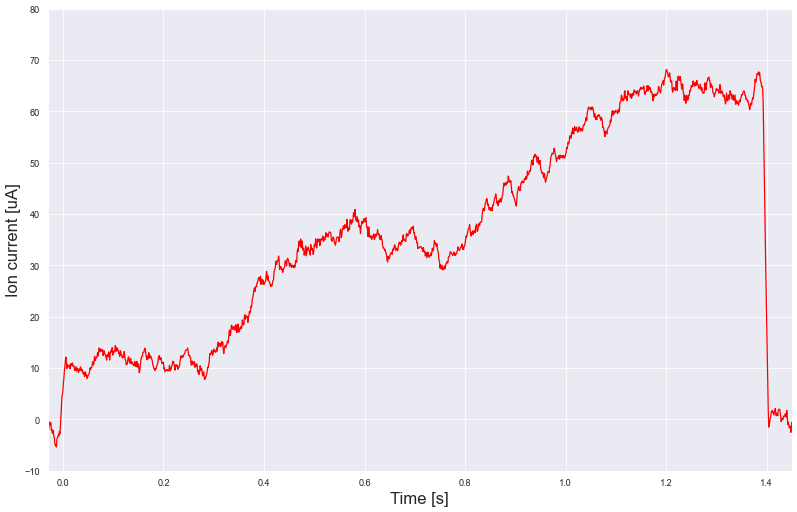

In [330]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(delta_t*id-t_ofs, DC_a * 10e5, color='red') # пересчет через коэф перччета датчика 10e5

plt.xlim([-.03, 1.45])
plt.ylim([-10, 80])

plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Ion current [uA]', fontsize=20)

None

# этот график без учета ускорения 

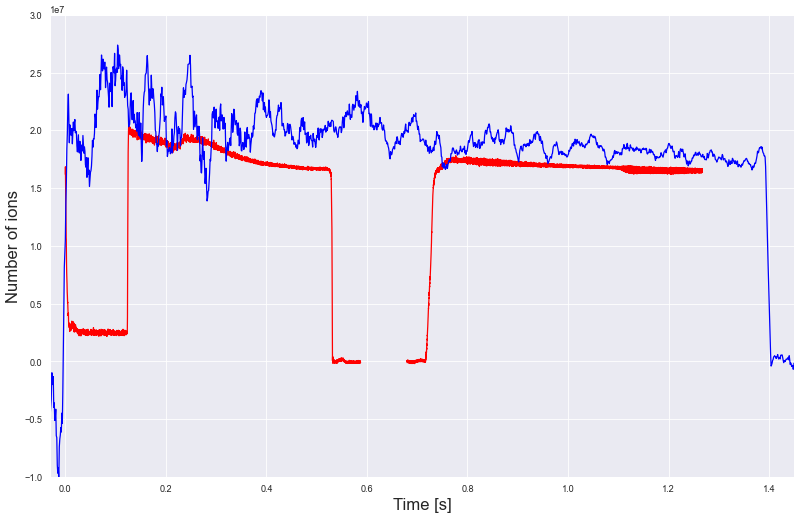

In [334]:
fig = plt.figure(figsize=(16, 10), dpi=60, facecolor="w", edgecolor="k")

plt.plot(t_21, N_21 - 0.9*10**6, color='red')
plt.plot(t_22, N_22 - 0.9*10**6, color='red')
plt.plot(delta_t*id-t_ofs, N_ion, color='blue')


plt.xlim([-.03, 1.45])
plt.ylim([-1*10**7, 3*10**7])

plt.xlabel('Time [s]', fontsize=20)
plt.ylabel('Number of ions', fontsize=20)

None

# данные интенсивности с быстрого и параметрического трасформаторов 